In [1]:
!pip install --user --upgrade pingouin

In [6]:
"""

데이터 출처 : https://www.kaggle.com/datasets/mylesoneill/world-university-rankings?resource=download&select=cwurData.csv

"""

# import modules
from IPython.display import display
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy import stats

import math
import csv
import pandas as pd
import numpy as np
import pingouin as pg

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',None)


# .csv 파일의 문제가 있어
def get_data(file_path):
    f = open(file_path, encoding='utf-8')
    reader = csv.reader(f)
    _list = []
    for i in reader:
        _list.append(i)
    f.close()
    df = pd.DataFrame(_list)
    df.columns = df.iloc[0,:]
    df = df.iloc[1:,:]
    return df

cwur = get_data('./cwurData.csv')
shanghai = get_data('./shanghaiData.csv')
times = get_data('./timesData.csv')

# edu_exp = get_data('./education_expenditure_supplementary_data.csv')
# edu_att =  get_data('./educational_attainment_supplementary_data.csv')
# school = get_data('./school_and_country_table.csv')

In [7]:
print(f'cwur shape : {cwur.shape}')
display(cwur.head(3))

print(f'shanghai shape : {shanghai.shape}')
display(shanghai.head(3))

print(f'times shape : {times.shape}')
display(times.head(3))

cwur shape : (2200, 14)


,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
1,1,Harvard University,USA,1,7,9,1,1,1,1,,5,100,2012
2,2,Massachusetts Institute of Technology,USA,2,9,17,3,12,4,4,,1,91.67,2012
3,3,Stanford University,USA,3,17,11,5,4,2,2,,15,89.5,2012


shanghai shape : (4897, 11)


,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year
1,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005
2,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005
3,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005


times shape : (2603, 14)


,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
1,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,,2011
2,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
3,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9,33%,37 : 63,2011


In [8]:
# 각 데이터 수집 시기를 맞추기 위해 같은 수집 연도들의 데이터만 추출 함.
cwur = cwur[cwur.year.isin(['2012','2013','2014','2015'])]
shanghai = shanghai[shanghai.year.isin(['2012','2013','2014','2015'])]
times = times[times.year.isin(['2012','2013','2014','2015'])]

In [9]:
#
cwur = cwur[cwur.institution.isin(shanghai.university_name.to_list())]
shanghai = shanghai[shanghai.university_name.isin(shanghai.university_name.to_list())]
times = times[times.university_name.isin(shanghai.university_name.to_list())]

shanghai = shanghai[shanghai.university_name.isin(cwur.institution.to_list())]
times = times[times.university_name.isin(cwur.institution.to_list())]

In [68]:
d = cwur.merge(shanghai, how='left', left_on=['institution','year'], right_on=['university_name','year'])
d = d.merge(times, how='left', left_on=['institution','year'], right_on=['university_name','year'])
d.dropna(inplace=True)

def f(str):
    try:
        x, y = str.split('-')
        return (int(x) + int(y)) / 2
    except:
        return float(str)

def f1(str):
    try:
        return str.split(':')[1]
    except:
        return str

d.world_rank = d.world_rank.apply(lambda x : f(x))
d.world_rank_x = d.world_rank_x.apply(lambda x : f(x))
d.world_rank_y = d.world_rank_y.apply(lambda x : f(x))

d['world_rank'] = round((d['world_rank_x'] + d['world_rank_y'] + d['world_rank']) / 3, 1)
d['female_male_ratio'] = d.female_male_ratio.apply(lambda x : x.split(':')[0])
d['international_students'] = d['international_students'].str.replace('%','').str.replace('','0').astype('int')
d['international_students'].apply(lambda x : d['international_students'].mean() if not x else x)

d['income'] = d['income'].str.replace('-','0')
d['income'] = d['income'].astype(float)
d['income'] = d['income'].apply(lambda x : d.income.mean() if not x else x)

d['num_students'] = d['num_students'].str.replace(',','')
d.loc[d.num_students == '','num_students'] = 0
d['num_students'] = d['num_students'].astype(float)
d['num_students'] = d['num_students'].apply(lambda x : d.num_students.mean() if not x else x)

d.loc[d.student_staff_ratio == '','student_staff_ratio'] = 0
d['student_staff_ratio'] = d['student_staff_ratio'].astype(float)
d['student_staff_ratio'] = d['student_staff_ratio'].apply(lambda x : d.student_staff_ratio.mean() if not x else x)

d.loc[d.female_male_ratio == '','female_male_ratio'] = 0
d['female_male_ratio'] = d['female_male_ratio'].astype(float)
d['female_male_ratio'] = d['female_male_ratio'].apply(lambda x : d.female_male_ratio.mean() if not x else x)

d.loc[d.ns == '','ns'] = 0
d['ns'] = d['ns'].astype(float)
d['ns'] = d['ns'].apply(lambda x : d.ns.mean() if not x else x)



d.drop(columns=['score','country_y','university_name_x','university_name_y','broad_impact','world_rank_y','world_rank_x','university_name_x','national_rank_x','university_name_y','national_rank_y','country_y','total_score_x','total_score_y'], inplace=True)
d.iloc[:,2:] = d.iloc[:,2:].astype(float)
col = d.columns.to_numpy()
col = col[[16,0,1,9,2,3,4,5,6,7,8,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25]]

d = d[col]
# d = d[d.year == 2015]

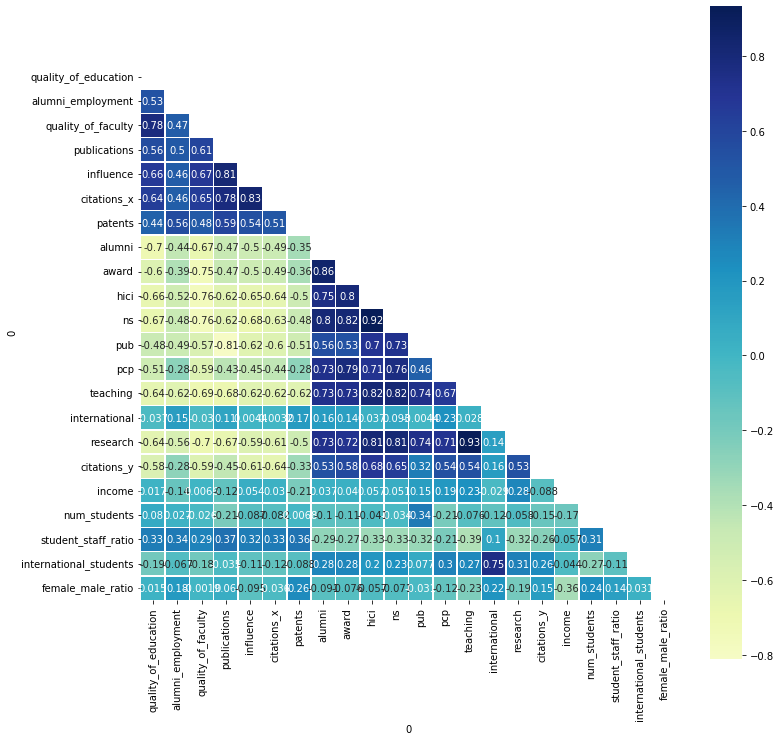

In [69]:
plt.figure(figsize=(12,12))
mask = np.zeros_like(d.iloc[:,4:].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(d.iloc[:,4:].corr(), annot=True, linewidth=.5, center=0, cmap='YlGnBu',square = True, mask=mask)
plt.show()

## 표준화 전처리 이전.

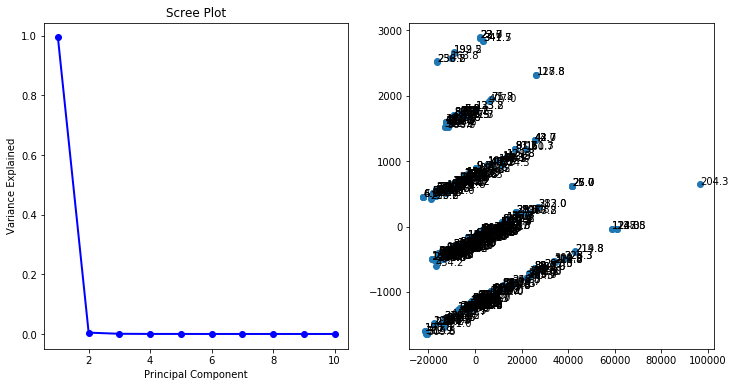

In [70]:
# 표준화 전처리 이전
a = PCA(n_components=10).fit(d.iloc[:,4:])
PC_values = np.arange(a.n_components_) + 1
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(PC_values, a.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

pca = PCA(n_components=2).fit_transform(d.iloc[:,4:])
plt.subplot(122)
plt.scatter(pca[:,0], pca[:,1])
for i in range(len(d)):
    plt.text(pca[i,0], pca[i,1], d.iloc[i,0])
plt.show()

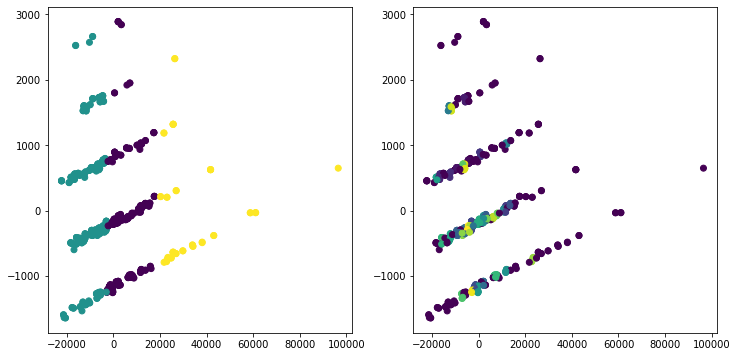

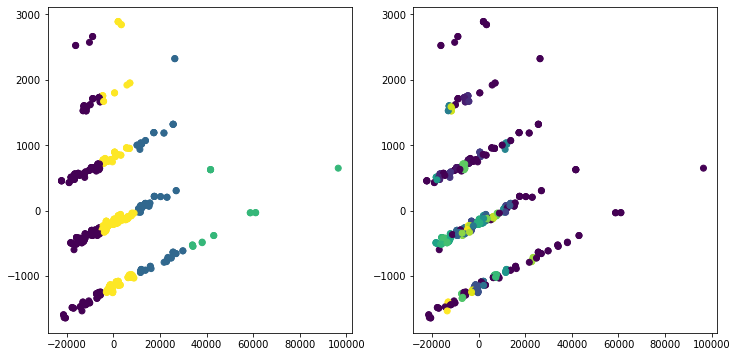

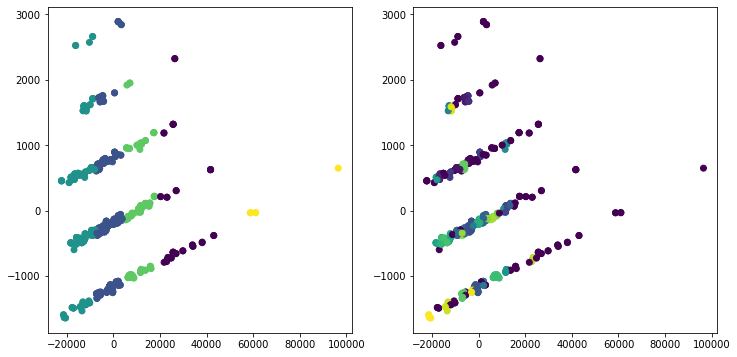

In [71]:
for i in range(3,6):
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    model = KMeans(n_clusters=i).fit(pca)
    plt.scatter(pca[:,0], pca[:,1], c=model.labels_)
    
    plt.subplot(122)
    model = DBSCAN(eps=100 * (i+1)).fit(pca)
    plt.scatter(pca[:,0], pca[:,1], c=model.labels_)
    plt.show()

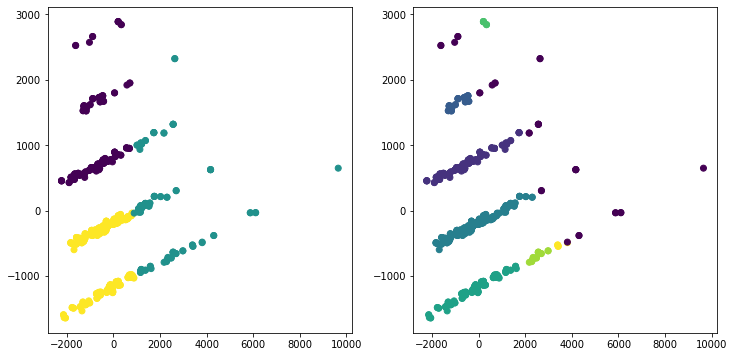

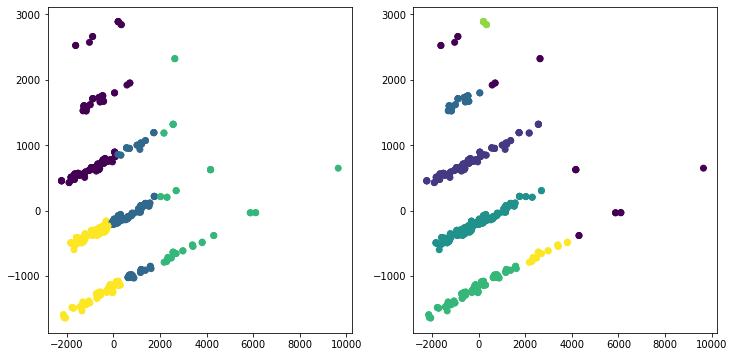

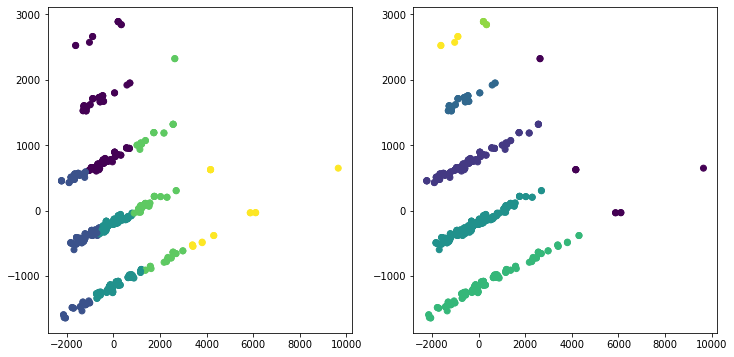

In [72]:
# 주성분 축 단위 변경
_pca = pca.copy()
_pca[:,0] = _pca[:,0] * 0.1
for i in range(3,6):
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    model = KMeans(n_clusters=i).fit(_pca)
    plt.scatter(_pca[:,0], _pca[:,1], c=model.labels_)
    
    plt.subplot(122)
    model = DBSCAN(eps=100 * (i+1)).fit(_pca)
    plt.scatter(_pca[:,0], _pca[:,1], c=model.labels_)
    plt.show()

In [73]:
model = DBSCAN(eps=100 * (6)).fit(_pca)
for i in set(model.labels_):
    print(f'{i} : ', d.iloc[model.labels_ == i, 0].mean())

0 :  126.69119999999998
1 :  180.47619047619048
2 :  173.6168949771689
3 :  220.076923076923
4 :  129.15
5 :  208.5
-1 :  115.2909090909091


## 표준화 작업 이후

In [54]:
scaler = StandardScaler()
d.iloc[:,4:] = scaler.fit_transform(d.iloc[:,4:])

# d[(d.values.ravel() == '').reshape(d.shape)]

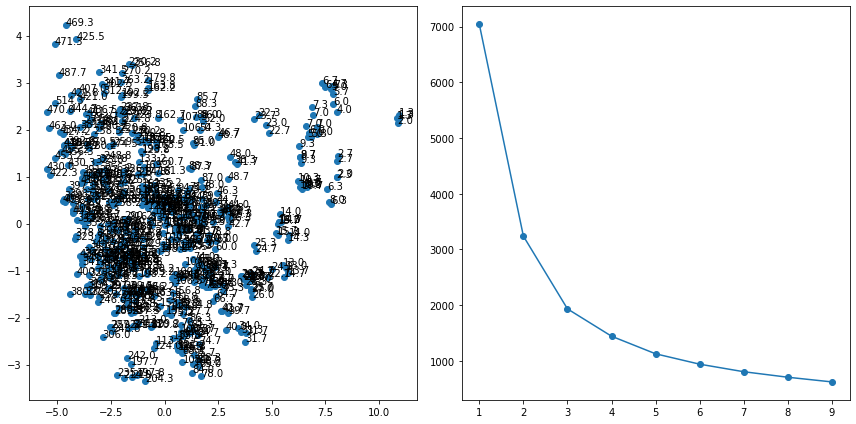

In [22]:
pca = PCA(n_components=2).fit_transform(d.iloc[:,4:])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(pca[:,0], pca[:,1])
for i in range(len(d)):
    plt.text(pca[i,0], pca[i,1], d.iloc[i,0])

plt.subplot(122)
distortions = []
for i in range(1,10):
    model = KMeans(n_clusters=i, random_state=0).fit(pca)
    distortions.append(model.inertia_)

plt.plot(range(1,10), distortions, marker='o')
plt.tight_layout()
plt.show()

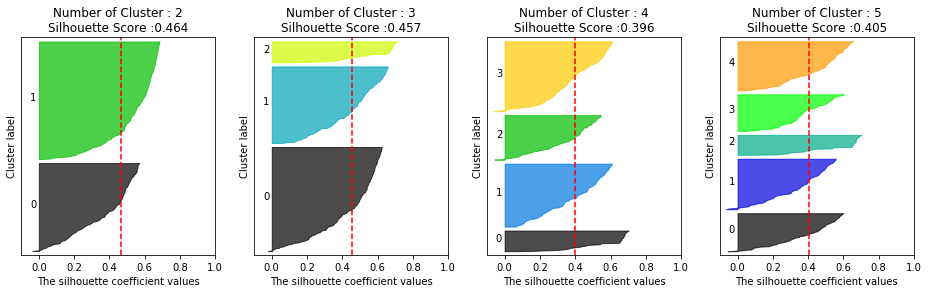

In [23]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 


    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

visualize_silhouette([2,3,4,5], pca)

## modeling

In [27]:
import warnings
warnings.filterwarnings(action='ignore')

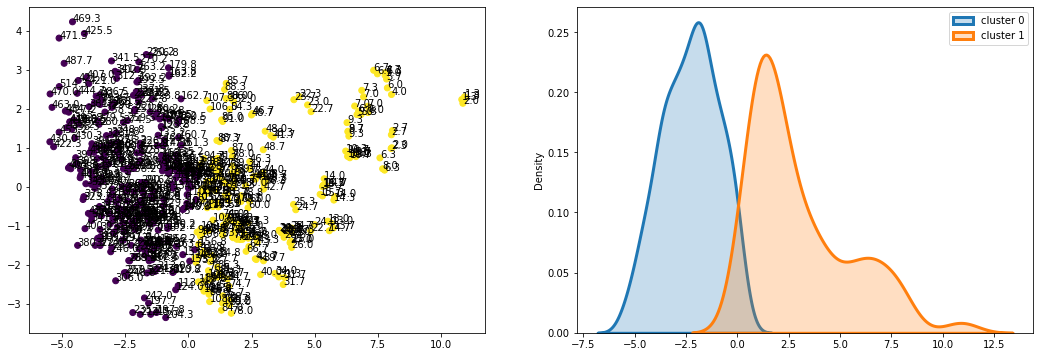

In [32]:
model = KMeans(n_clusters=2).fit(pca)

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.scatter(pca[:,0], pca[:,1], c=model.labels_)
for i in range(len(d)):
    plt.text(pca[i,0], pca[i,1], d.iloc[i,0])

plt.subplot(122)
sns.distplot(pca[model.labels_ == 0,0], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 3}, 
            label = 'cluster 0')
sns.distplot(pca[model.labels_ == 1,0], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 3}, 
            label = 'cluster 1')
plt.legend()
plt.show()

In [33]:
print(f'cluster 0 mean world_rank : {d.loc[model.labels_ == 0, "world_rank"].mean()}')
print(f"cluster 1 mean world_rank : {d.loc[model.labels_ == 1, 'world_rank'].mean()}")

cluster 0 mean world_rank : 261.0473015873017
cluster 1 mean world_rank : 58.327118644067774


## evaluation.

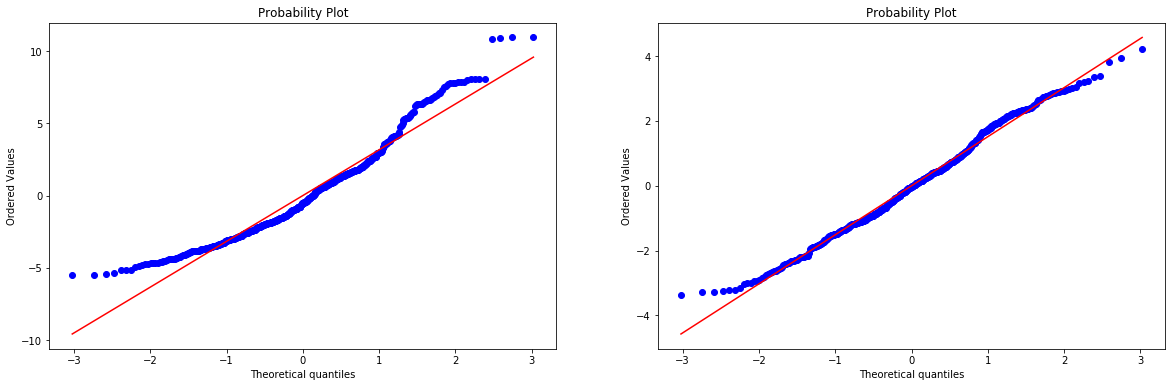

In [34]:
# 평균 비교를 위한 정규성 검정
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

stats.probplot(pca[:,0], dist=stats.norm, plot=ax1)
stats.probplot(pca[:,1], dist=stats.norm, plot=ax2)
plt.show()

In [35]:
# 두 표본 모두 정규성 가정을 만족한다고 본다
# 정규성을 충족하는 데이터들의 등분산 검정
stats.bartlett(pca[:,0],pca[:,1]) # p-value가 매우 작으므로 귀무가설 기각, 등분산 성립안함.

BartlettResult(statistic=292.2766427449464, pvalue=1.5867300181741946e-65)

In [40]:
pg.pairwise_gameshowell(data = pd.DataFrame(pca).melt(), dv='value', between='variable')
# pval이 매우 높으므로 두 표본의 평균은 유의미하게 다르다는 것을 확인할 수 있다.

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,0,1,1.611939e-17,-1.702611e-17,3.314550e-17,0.152449,2.174197e-16,778.755832,1.0,1.309006e-17


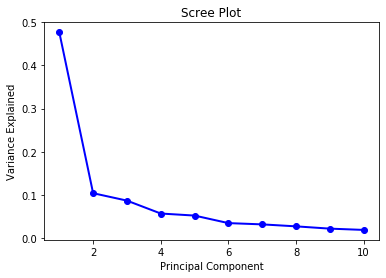

In [43]:
# 주성분 분산 설명력
a = PCA(n_components=10).fit(d.iloc[:,4:])
PC_values = np.arange(a.n_components_) + 1
plt.plot(PC_values, a.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [52]:
# 주성분의 설명력을 확인해보면
_df = pd.DataFrame(a.components_.T, index=d.columns[4:],columns=[f'PC_{i}' for i in range(1,11)])
_df

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,,,,,,,,,,
quality_of_education,-0.243783,-0.013214,-0.072999,0.193581,-0.058009,0.092745,-0.298626,-0.181808,0.522062,-0.185787
alumni_employment,-0.191592,0.193497,0.136279,0.079198,0.153820,0.406076,-0.295375,-0.492276,-0.095410,0.426330
quality_of_faculty,-0.259565,-0.007874,-0.103452,0.053474,-0.131703,0.047562,-0.159854,-0.049394,0.243380,-0.393439
publications,-0.241140,0.254291,-0.109011,-0.059372,0.235561,-0.161372,0.118120,0.172826,0.156421,0.095604
influence,-0.243924,0.126927,-0.225863,0.146766,0.167920,-0.227192,-0.101131,0.129924,0.116031,0.069513
citations_x,-0.240574,0.120383,-0.197421,0.149538,0.178923,-0.259548,-0.121290,0.182351,0.146639,0.216229
patents,-0.192415,0.241793,0.150577,0.068672,0.283634,0.079961,-0.244984,0.074669,-0.486849,-0.578910
alumni,0.252515,0.162432,-0.037219,0.061028,0.253341,-0.210898,-0.043753,0.057051,-0.180985,0.061732
award,0.253630,0.175266,-0.031941,0.067193,0.309428,-0.109307,-0.068663,-0.021147,0.051687,0.179053


In [ ]:
# 따라서 hici,ns,teaching 를 집중적으로 높이면 상위 군집으로 이동이 가능하다.